## EDA와 Feature-engineering을 통한 대출 상환여부 예측

#### reference
* Home Credit Default Risk - A Gentle Introduction <br>

https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction <br>
https://bkshin.tistory.com/entry/캐글-5-Home-Credit-Default-Risk


### 대회 설명
각 고객의 정보를 기반으로 해당 고객이 대출한 돈을 갚을 수 있을지 없을지에 대한 확률을 예측하는 대회 <br>
(supervised classification task)
> * 0 이면 대출상환 가능, 1이면 대출상환 어려움
* 주어진 여러 데이터 테이블이 있지만, 이 노트북에서는 메인 테이블 application_train, application_test만 사용할 예정

### Metric : ROC AUC
AUC-ROC 곡선은 다양한 임계값에서 모델의 분류 성능에 대한 측정 그래프
* ROC = 모든 임계값에서 분류 모델의 성능을 보여주는 그래프
* AUC(Area Under the Curve) = ROC곡선아래영역
    * 우수한 분류모델은 AUC값이 1에 가깝고, 클래스를 분류하는 성능이 뛰어남을 의미
    * AUC 최소값은 0.5으로, 이 경우 모델의 클래스 분리 능력이 전혀 없음을 뜻함
    
    > AUC해석
      * AUC=0.7이면, 해당 분류 모델이 양성 클래스와 음성 클래스를 구별할 수 있는 확률은 70%
    
#### ROC-curve에서의 수식
* True positive rates(=recall, sensitivity)
    * TPR = R = TP / (TP+FN)
        * 실제 암 환자 중에서 암환자라고 맞춘 확률
* True negative rates(=specificity)
    * TNR = TN / (TN+FP)
        * 실제 정상인 환자 중에서 정상이라고 맞춘 확률
* ROC-curve에서 x축, y축
    * y축 : TPR(=Recall)
    * x축 : 1-(TNR)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# List files available
print(os.listdir("../input/"))

['home-credit-default-risk']


In [4]:
# Training data
app_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Testing data features
app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------
## Exploratory Data Analysis

## 1) Target 컬럼의 분포를 살펴보자
Target은 우리가 예측해야하는 값이다. 0이면 제때 대출금 상환 가능한것, 1이면 상황이 어려운것을 의미한다. 

In [6]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

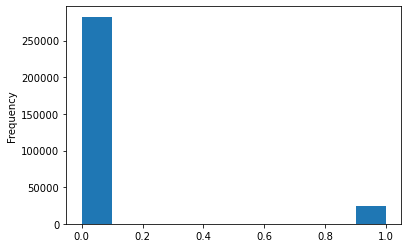

In [7]:
app_train['TARGET'].astype(int).plot.hist();

* 대출을 상환할 수 있는 0값이 1보다 훨씬 많은 imbalanced data이다.

## 2) 결측치 확인
각 컬럼별 결측치 개수 및 비중 확인

In [8]:
def missing_values_table(df):
    # 전체 결측치 개수 확인
    mis_val=df.isnull().sum()
    
    # 결측치 비중 확인
    mis_val_percent=100*df.isnull().sum()/len(df)
    
    # 결측치 개수 , 결측치 비중 테이블 만들기
    mis_val_table=pd.concat([mis_val, mis_val_percent],axis=1)
    
    # 컬럼 이름바꾸기
    mis_val_table_ren_columns=mis_val_table.rename(columns={0:'Missing Values',1:'% of Total Values'})

    # 결측치 0인 컬럼은 제외하고 정렬
    mis_val_table_ren_columns=mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values('% of Total Values',ascending=False).round(1)

    # 요약 결과 print
    print("app_train의 전체 컬럼 개수는 "+str(df.shape[1])+"개 이다.\n"
         "그 중에서 결측치가 있는 컬럼 개수는 "+str(mis_val_table_ren_columns.shape[0])+'개 이다.')
    
    return mis_val_table_ren_columns

In [9]:
missing_values=missing_values_table(app_train)
missing_values.head(20)

app_train의 전체 컬럼 개수는 122개 이다.
그 중에서 결측치가 있는 컬럼 개수는 67개 이다.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


* 머신러닝 모델을 만드려면, 위의 결측치들을 채워야한다.(imputation)
* 뒷부분에서 imputation없이 결측치를 채울 수 있는 XGBoost 모델을 사용할것이다.
* 또 다른 방법으로는 결측치가 너무 많은 컬럼은 삭제할수도있지만, 해당 컬럼이 모델 성능에 도움이 될수도 있기 때문에 우선 유지하기로한다.

## 3) Column Types
int64, float64 타입은 수치형변수이고 object 타입은 범주형 변수

In [10]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [11]:
# 범주형 변수에서 유니크한 값의 개수를 살펴보자
# app_train.select_dtypes('object').apply(pd.Series.nunique)
app_train.select_dtypes('object').nunique()   # apply함수 없이 가능

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

* 대부분의 범주형 변수는 유니크한 값이 적은것으로 보인다.
    * ORGANIZATION_TYPE 와 OCCUPATION_TYPE 는 예외

## 4) 범주형 변수 Encoding
LightGBM같은 모델을 제외하고 대부분의 머신러닝 모델은 범주형 변수를 다룰 수 없기 때문에, 이러한 범주형 변수를 encode해줘야 한다. 그 방법으로는 아래 두가지가 있음
* 1) Label encoding :
    * 범주형 변수의 개별값을 숫자로 바꿔주는 방법. 컬럼을 새로 생성하지 않음
    * 여성/남성 처럼 범주형 변수의 값이 두개일경우는 Label encoding을 사용해도 무관하지만, 그 이상일경우는 One-hot encoding을 사용하는것이 좋음
* 2) One-hot encoding :
    * 피처 값의 유형에 따라 새로운 피처를 추가해 고유 값에 해당하는 칼럼에만 1을 표시하고 나머지 칼럼에는 0을 표시하는 방법
    * One-hot encoding의 경우 범주형 변수의 유니크한값의 개수만큼 컬럼이 늘어난다는것
        * 이를 보완하기 위해 PCA같은 차원축소 방법을 사용할수도있음
        
> 이 노트북에서는 범주형변수의 유니크한 값이 2개일경우 Label encoding을 사용하고 그 이상일 경우 One-hot encoding을 사용할것다.

### Label Encoding and One-Hot Encoding
* LabelEncoder(), get_dummies() 활용

In [12]:
le=LabelEncoder()
le_count=0

# 컬럼별로 iterate 돌기
for col in app_train:
    if app_train[col].dtype=='object':
        # 데이터타입이 object이고 값의 종류가 두개 이하일경우,
        if len(list(app_train[col].unique())) <=2:
            
            # train과 test에 동일하게 라벨인코딩을 하기위해 train기준으로 fit한값을 train,test에 동일하게 transform해줌
            le.fit(app_train[col])
            
            # train-set, test-set 둘다 Transform
            app_train[col]=le.transform(app_train[col])
            app_test[col]=le.transform(app_test[col])
            
            # 라벨인코딩을 한 컬럼이 몇개인지 카운트
            le_count+=1
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [13]:
# 위에서 Label-encoding적용 안한 나머지 범주형 변수에 One-hot encoding 적용
app_train=pd.get_dummies(app_train)
app_test=pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


## 5) Train데이터와 Test데이터 컬럼 맞춰주기
train 데이터와 test 데이터에는 동일한 feature가 있어야 한다. <br>
train 데이터에 있는 카테고리변수의 유니크한 값 개수와 test 데이터에 있는 카테고리 변수의 유니크한 값 개수가 다른 변수들이 있어서 one-hot-encoding을 했더니, train에는 있는데 test에 없는 컬럼들이 생겨버림.<br>
<br>
따라서 test 데이터에 없고 train에만 있는 컬럼을 삭제해야됨. <br>
> 우선, train 데이터에서 TARGET 컬럼을 뽑아낸다. 
    * TARGET 컬럼은 test데이터에 없어도 train 데이터에는 반드시 있어야하기 때문에

> align() 함수의 join메소드를 inner로 적용해서 교집합으로 있는 변수만 추린다.

#### Python align() 함수
* 두 데이터 프레임에 포함 된 데이터를 변경하지 않고 두 데이터 프레임간에 행 및 / 또는 열의 배열이 동일한 지 확인할때 사용

In [14]:
# 예시
df1 = pd.DataFrame([[1,2,3,4], [6,7,8,9]], columns=['D', 'B', 'E', 'A'], index=[1,2])
df2 = pd.DataFrame([[10,20,30,40], [60,70,80,90], [600,700,800,900]], columns=['A', 'B', 'C', 'D'], index=[2,3,4])

In [15]:
df1

,D,B,E,A
1,1,2,3,4
2,6,7,8,9


In [16]:
df2

,A,B,C,D
2,10,20,30,40
3,60,70,80,90
4,600,700,800,900


In [17]:
# 두 데이터프레임에 둘다 포함되어있는 D,B,A 컬럼만 남김
a1, a2 = df1.align(df2, join='inner', axis=1)
print(a1)
print(a2)

   D  B  A
1  1  2  4
2  6  7  9
     D    B    A
2   40   20   10
3   90   70   60
4  900  700  600


In [18]:
# TARGET변수는 train데이터에만 있지만 필요한 변수이기때문에 따로 빼두고나서 다시추가할것
train_labels=app_train['TARGET']

"""
두 데이터프레임에 모두 있는 컬럼들만 유지하면서 train-set과 test-set을 align한다.
즉, train 데이터와 test 데이터에 둘다 있는 컬럼들의 값만 가져오려는것
"""

app_train, app_test=app_train.align(app_test,join='inner',axis=1)

# TARGET변수 다시 추가
app_train['TARGET']=train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


## 6) Back to Exploratory Data Analysis

### 6-1) 이상치 (Anomalies)
* 이상치를 발견할 수 있는 방법중 하나는 describe()메소드로 컬럼의 통계값들을 보는것이다.

In [19]:
# DAYS_BIRTH 컬럼에서는 이상치 없어보임
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [20]:
# DAYS_EMPLOYED는 이상치..
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

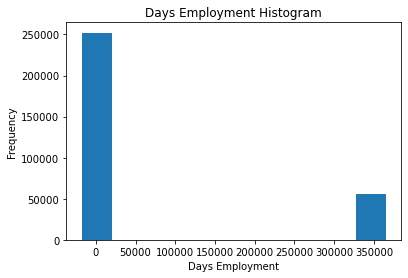

In [21]:
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment');

이상치인것 같은 고객들은 따로 빼서 그들의 대출상환 비율이 그외의 고객들에비해 높거나 낮은 경향이 있는지 파악해보자


In [22]:
# 이상치
anom=app_train[app_train['DAYS_EMPLOYED']==365243]
# 이상치 외
non_anom=app_train[app_train['DAYS_EMPLOYED']!=365243]

print('The non-anomalies default on %0.2f%% of loans' %(100*non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


* 이상치로 보이는 고객들이 대출을 상환하지못할 확률이 5.4%로 더 낮음.
* 이상치를 다루는 가장 안전한 방법은 결측치 채우듯이 채우는 방법
* 이 경우 모든 이상치들이 같은값을 갖고 있으므로, 다 같은 값으로 채울것이다.
* 이상값들이 중요해보이니, 머신러닝 모델에 이 이상값들을 임의로 채운것에대해 알려줄것이다.

> 결론적으로
    * 이상값을 숫자로 채우지 않고, 새로운 boolean 컬럼을 만들어서 이상값인지 아닌지를 구분할것이다.

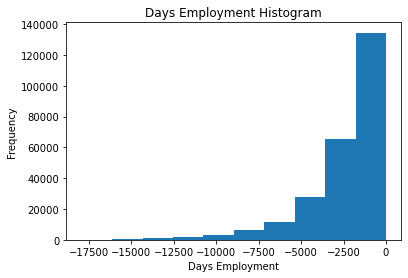

In [23]:
# Create an anomalous flag column
## 이상치(365243)인 값에 대해서 True , False로 구분
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# 이상치를 nan값으로 대치
app_train['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)

app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment');

In [24]:
# test 데이터에도 train 데이터와 동일하게 작업
app_test['DAYS_EMPLOYED_ANOM']=app_test['DAYS_EMPLOYED']==365243
app_test['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)

# True, False로 되어있는 데이터 sum하면 True인것 개수 카운팅됨.
print('There are %d anomalies in the test data out of %d entries'%(app_test['DAYS_EMPLOYED_ANOM'].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### 6-2) Correlations
이제 카테고리형 변수와 outlier를 다뤄보자. <br>
데이터를 이해하는 방법중 하나는 변수간, 그리고 target과의 상관관계를 살펴보는것이다. <br>
.corr()를 사용해서 변수간, 그리고 target변수와의 Pearson 상관관계를 살펴보자.

In [25]:
# TARGET 변수와의 상관관계
correlations=app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

* DAYS_BIRTH 컬럼이 가장 양의 상관성이 높다. 양의 상관을 띄지만, 이 변수의 값들은 실제로 음수이다. 
    * 이 의미는 고객 나이가 많을수록 대출 상환할 가능성이 적다? 라는 해석이 나오는데 DAYS_BIRTH가 음수여서 그렇게 나타난것으로 보임. 따라서, DAYS_BIRTH에 절댓값을 취해서 다시 상관관계를 보려고 함.

### 6-3) Effect of Age on Repayment

In [26]:
# DAYS_BIRTH의 절대값과 TARGET변수와의 상관계수
app_train['DAYS_BIRTH']=abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

* 절대값을 취해서 다시 TARGET과의 상관계수를 보니 고객의 나이가 많을수록, 대출을 제때 상환할 가능성이 높다고 나옴.

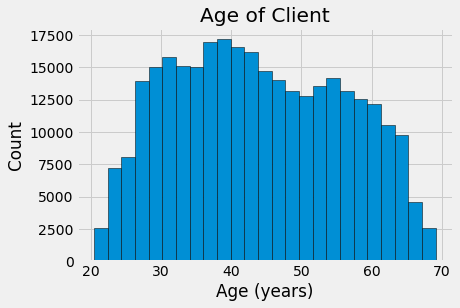

In [27]:
plt.style.use('fivethirtyeight')

# 고객 나이에 대한 히스토그램 분포 확인
plt.hist(app_train['DAYS_BIRTH']/365, edgecolor='k',bins=25)
plt.title('Age of Client');
plt.xlabel('Age (years)');
plt.ylabel('Count');

* 위의 분포를 살펴보니 outlier없이 나이가 고르게 분포되어있는 편. 
* 이제 나이가 TARGET에 미치는 영향을 시각화해서 보기위해 KDE plot을 그려볼것이다.

> KDE plot을 사용하는 이유
* 보통 분포를 확인할 때 히스토그램을 많이 활용한다. 그런데 히스토그램은 구간을 어떻게 설정하냐에 따라 결과물이 매우 달라져서 엉뚱한 결론과 해석을 내릴 수 있음.
* 그래서 그 대안으로 커널 밀도 추정(KDE) 그래프를 많이 사용함.
    * 히스토그램 같은 분포를 곡선화해서 나타낸 그래프

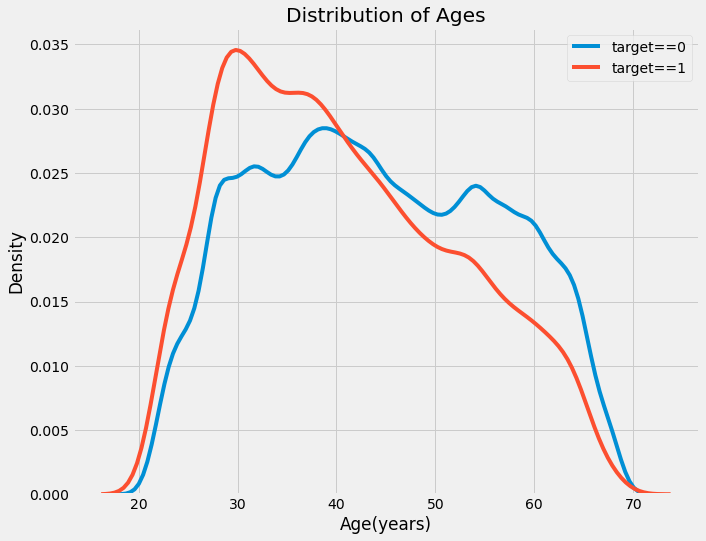

In [28]:
plt.figure(figsize=(10,8))

# 제때 대출을 상환하는 고객의 나이 plot (TARGET=0)
sns.kdeplot(app_train.loc[app_train['TARGET']==0,'DAYS_BIRTH']/365,label='target==0')

# 제때 대출을 상환하지못하는 고객의 나이 plot (TARGET=1)
sns.kdeplot(app_train.loc[app_train['TARGET']==1,'DAYS_BIRTH']/365,label='target==1')

plt.xlabel('Age(years)');
plt.ylabel('Density');
plt.title('Distribution of Ages');

* target==1(빨간색) 의 분포를 보면 20-30대에 기울어 있는것을 볼 수 있다. 이는 젊은 층일수록 대출 상환을 못할 확률이 높다고 유추할 수 있음.
* target==0일때와 1일때의 TARGET과의 분포가 상이한것으로 보아 이 변수는 머신러닝 모델에 유용하게 활용될 것으로 보인다.
* 그럼이제 나이를 나이대 별로 그룹을 나눠서 target=1(대출 상환이 어려운) 의 평균값을 살펴보자.

In [29]:
# 최소 20 최대 70으로해서 총 10개로 그룹핑
## 결과는 20이상 25미만, 25이상 30미만,,,, 으로 그룹핑됨. 단 (,)는 포함 [,]는 미포함을 의미
np.linspace(20,70,num=11)

array([20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70.])

In [30]:
"""
cut() 함수를 사용해서 5살 간격으로 나이대 그룹을 나눠보자. 
그다음, 각 나이대 별로 대출상환을 못하는 비율을 체크
"""

age_data=app_train[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH']=age_data['DAYS_BIRTH']/365

# Bin the age data
age_data['YEARS_BINNED']=pd.cut(age_data['YEARS_BIRTH'],bins=np.linspace(20,70,num=11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [31]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


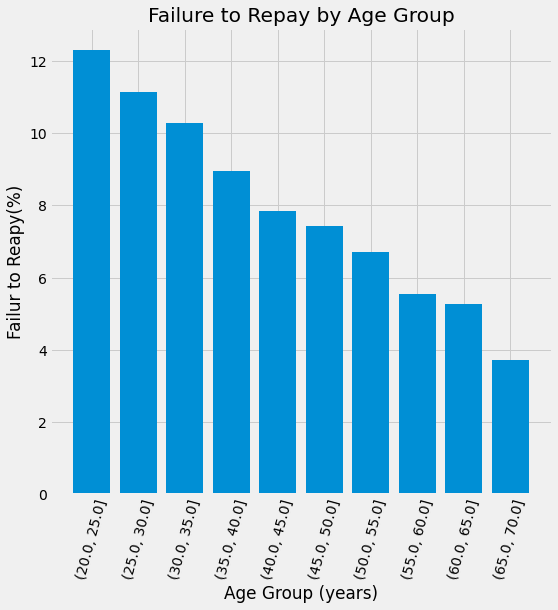

In [32]:
plt.figure(figsize=(8,8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation=75);
plt.xlabel('Age Group (years)');
plt.ylabel('Failur to Reapy(%)')
plt.title('Failure to Repay by Age Group');

* 젊은층일수록 대출을 상환하지 못하는 것으로 나타남
* 20-25세, 25-30세 30-35세는 각각 약10% 이상 대출을 상환하지 못했고, 55-60세, 60-65세, 65-70세는 5%이하로 대출을 상환하지 못했음.

### 6-4) Exterior Sources
* 음의 상관이 가장 높았던 3개의 변수 EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 이다.
    * 이 변수들은 외부에서 가져온 정규화된 score를 나타낸다.
* 그럼, 이제 TARGET 변수와 EXT_SOURCE와의 상관관계와 EXT_SOURCE 서로간의 상관관계를 살펴보자

In [33]:
ext_data=app_train[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs=ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


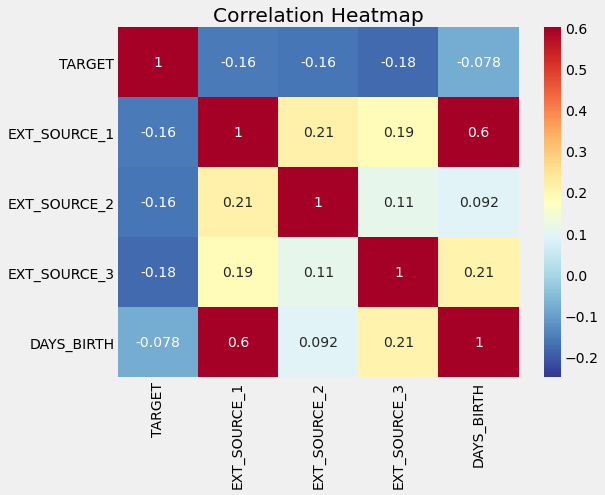

In [34]:
plt.figure(figsize=(8,6))

sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap');

* EXT_SOURCE와 TARGET 변수는 음의 상관성을 띄므로, EXT_SOURCE값이 증가할수록 대출 상환을 잘한다는 의미로 해석가능.
* 또한, DAYS_BIRTH 변수는 EXT_SOURCE_1 변수와 양의 상관성이 높은것으로 보아 이 score중 하나는 고객의 나이일것으로 추정된다.
* 그 다음은 각 EXT_SOURCE 를 TARGET값 별로 나눠서 분포를 살펴보자.

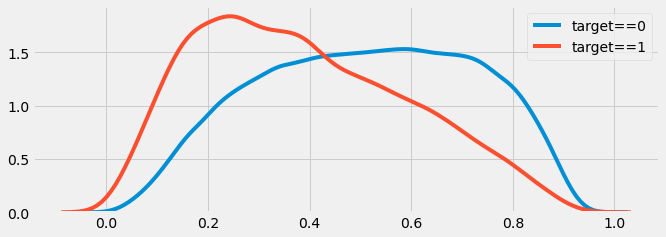

In [35]:
plt.figure(figsize=(10,12))
plt.subplot(3,1,1);
sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'EXT_SOURCE_1'],label='target==0')
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'EXT_SOURCE_1'],label='target==1');

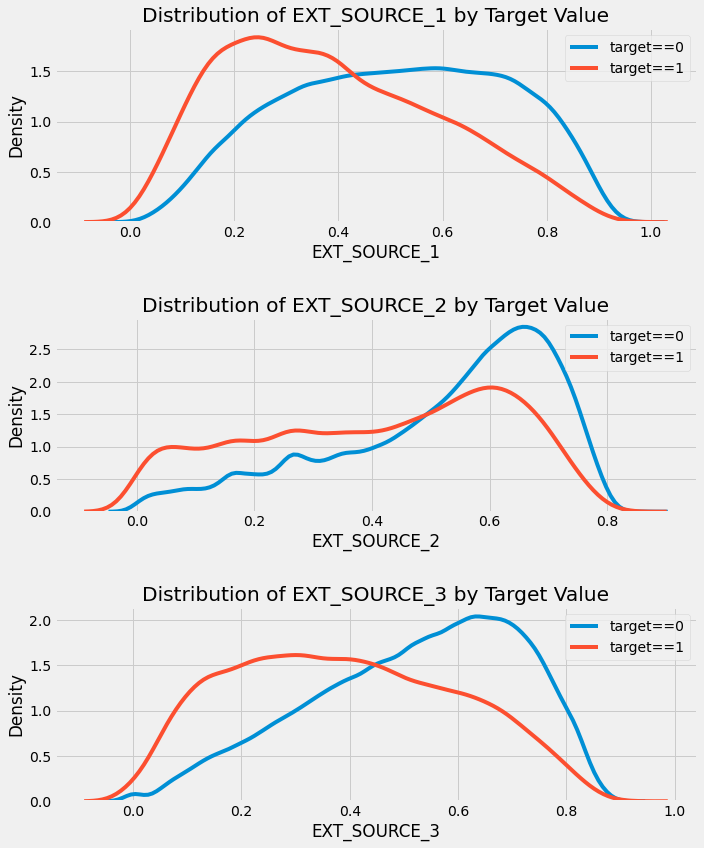

In [36]:
plt.figure(figsize=(10,12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']):
    plt.subplot(3,1,i+1)
    
    sns.kdeplot(app_train.loc[app_train['TARGET']==0,source],label='target==0')
    sns.kdeplot(app_train.loc[app_train['TARGET']==1,source],label='target==1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' %source);
    plt.ylabel('Density');
plt.tight_layout(h_pad=2.5)

* EXT_SOURCE_3 변수는 target값에 따라 차이가 가장 큰것으로 보인다.
* target 과의 상관계수가 그리 높지는 않지만, target이 0인지 1인지에 따라 값이 다른것으로 보아 모델에 영향을 주는 주요 변수라고 판단할 수 있음.

### 6-5) Pairs Plot
* EXT_SOURCE 와 DAYS_BIRTH 변수간의 pair plot을 그려보자. 
* pair plot은 각각의 분포를 보여줄 뿐만 아니라, 여러 변수간의 관계도 보여주는 좋은 시각화이다.

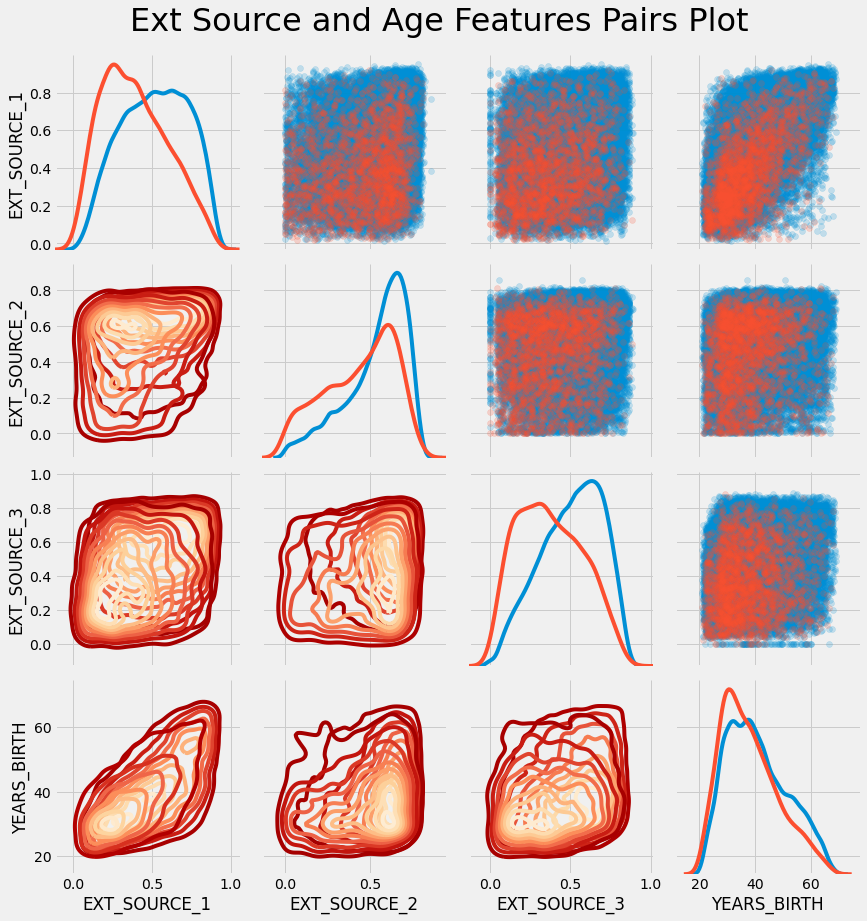

In [37]:
# Copy the data for plotting
plot_data=ext_data.drop(columns=['DAYS_BIRTH']).copy()

# 고객 나이 컬럼 추가
plot_data['YEARS_BIRTH']=age_data['YEARS_BIRTH']

# 결측치 drop
plot_data=plot_data.dropna().loc[:100000,:]

# 두 컬럼 간의 상관관계를 계산하는 함수 작성
def corr_func(x,y,**kwargs):
    r=np.corrcoef(x,y)[0][1]
    ax=plt.gca()
    ax.annotate("r={:.2f}".format(r),
               xy=(.2, .8),
               xycoords=ax.transAxes,
               size=20)

# Create the pairgrid object
## vars = 변수명 리스트
grid=sns.PairGrid(data=plot_data, size=3, diag_sharey=False, hue='TARGET',
                 vars=plot_data.columns.drop(['TARGET']).tolist())

# 삼각형 위쪽 영역은 산점도
grid.map_upper(plt.scatter,alpha=0.2)

# 대각선은 히스토그램
grid.map_diag(sns.kdeplot)

# 삼각형 하단은 density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot',size=32, y=1.05);

* 위의 결과에서 빨간색은 대출 상환을 못하는경우, 파란색은 대출 상환하는 경우를 나타냄.
* EXT_SOURCE_1과 YEARS_BIRTH 간의 양의 선형관계가 나타난다.


## 7) Feature Engineering
* 기존 데이터를 활용해서 새로 feature를 추가한다거나, 중요한 변수만 고른다거나, 차원을 줄이는 방식 등 여러가지 feature engineering 방법이 있음.<br>
이 노트북에서는 아래 두가지 방법의 feature engineering을 해볼것이다.

### 7-1) Polynomial Features
> 곡선 형태를 띄는 데이터를 제곱, 세제곱의 값으로 만들어서 일차방정식이 되도록 할 수 있음. 이렇게 dataset의 feature를 조정하여 다항식을 일차방정식으로 만들면 Gradient Descent 같은 알고리즘을 사용해서 학습시킬수 있음.

* 여기에서는 EXT_SOURCE_1를 제곱한값과 EXT_SOURCE_2를 제곱한 값, 그리고 EXT_SOURCE_1 x EXT_SOURCE_2 와 EXT_SOURCE_1 x EXT_SOURCE_2^2 같은 두 변수간의 곱을 새로운 변수로 만들 수 있다.이러한 변수를 상호작용항 이라고 한다.

* 어떤 변수 각각은 target변수에 영향을 미치지 않을 수 있지만, 이 두 변수를 결합했을때 target변수에 영향을 미칠 수 있다.

* 상호작용항은 통계모델에서 다수의 변수들의 효과를 파악하기위해 사용되곤한다. 하지만 머신러닝에는 자주 사용되는것을 보지는 못했다. 그래서 한번 이 상호작용항이 모델예측력에 도움이 되는지 체크해볼것이다.

* 아래 코드에서 EXT_SOURCE, DAYS_BIRTH 변수를 사용해서 polynomial feature를 만들어볼것이다.


In [38]:
'''
우선 다항식 적용할 변수들의 null값을 imputer로 채워준다.
'''
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# 결측치 처리를 위해 imputer 호출
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# target값 따로 저장
poly_target=poly_features['TARGET']
# target값 제외한 나머지 변수 저장 
poly_features=poly_features.drop(columns=['TARGET'])

# 결측치 impute로 메꾸기 (train 데이터 기준으로 fit하고, train과 test에 둘다 transform 적용)
'''
train set 기준의 평균, 중간값 또는 최빈값으로 새로운 데이터의 null값을 채우는것
'''
poly_features=imputer.fit_transform(poly_features)
poly_features_test=imputer.transform(poly_features_test)


In [39]:
# imputer 적용 후
poly_features

array([[8.30369674e-02, 2.62948593e-01, 1.39375780e-01, 9.46100000e+03],
       [3.11267311e-01, 6.22245775e-01, 5.35276250e-01, 1.67650000e+04],
       [5.05997931e-01, 5.55912083e-01, 7.29566691e-01, 1.90460000e+04],
       ...,
       [7.44026400e-01, 5.35721752e-01, 2.18859082e-01, 1.49660000e+04],
       [5.05997931e-01, 5.14162820e-01, 6.61023539e-01, 1.19610000e+04],
       [7.34459669e-01, 7.08568896e-01, 1.13922396e-01, 1.68560000e+04]])

In [40]:
poly_features_test

array([[ 7.52614491e-01,  7.89654351e-01,  1.59519540e-01,
        -1.92410000e+04],
       [ 5.64990202e-01,  2.91655532e-01,  4.32961667e-01,
        -1.80640000e+04],
       [ 5.05997931e-01,  6.99786830e-01,  6.10991328e-01,
        -2.00380000e+04],
       ...,
       [ 7.33503500e-01,  6.32769551e-01,  2.83711883e-01,
        -1.59220000e+04],
       [ 3.73090081e-01,  4.45700983e-01,  5.95456203e-01,
        -1.39680000e+04],
       [ 5.05997931e-01,  4.56540667e-01,  2.72133684e-01,
        -1.39620000e+04]])

In [41]:
from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer=PolynomialFeatures(degree=3)

In [42]:
# Train the polynomial features (train데이터 기준으로 fit)
poly_transformer.fit(poly_features)

# Transform the features
poly_features=poly_transformer.transform(poly_features)
poly_features_test=poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


* get_feature_names 메소드를 사용해서 다항식 적용한 변수이름 확인

In [43]:
poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

* 35개의 feature가 만들어진것을 확인.이제 이 새로운 Feature들이 target과 상관관계가 있는지 확인해보자

In [44]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))
# drop했던 TARGET변수 다시 추가
poly_features['TARGET']=poly_target

# TARGET변수와의 상관관계 확인
poly_corrs=poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


* 다항식으로 만들어진 몇몇 새로운 변수들은 기존 변수보다 상관관계가 더 높다.<br>
(위에서 기존 변수와 TARGET변수와의 상관관계중 가장 높았던 값이 EXT_SOURCE_3 변수가 -0.18이었는데, 두 변수 EXT_SOURCE_2 EXT_SOURCE_3 를 조합한 변수는 -0.19로 더큼)

* 실제 이 변수가 모델에 영향이 있는지는 이 변수를 넣었을때와 뺐을때 둘다 테스트해보면된다.


In [45]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# 원본 train 데이터에 새로 만든 다항변수를 merge해서 새로운 데이터셋 만들기
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# 원본 test 데이터에 새로 만든 다항변수를 merge해서 새로운 데이터셋 만들기
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes => train데이터셋 기준으로 align 
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


### 7-2) Domain Knowledge Features
* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [46]:
app_train_domain=app_train.copy()
app_test_domain=app_test.copy()

# train데이터에 새로운 변수 추가
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [47]:
# test데이터에 새로운 변수 추가
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

* domain기반으로 새로 만든 변수를 TARGET별로 다른 컬러로 KDE plot을 그려보자

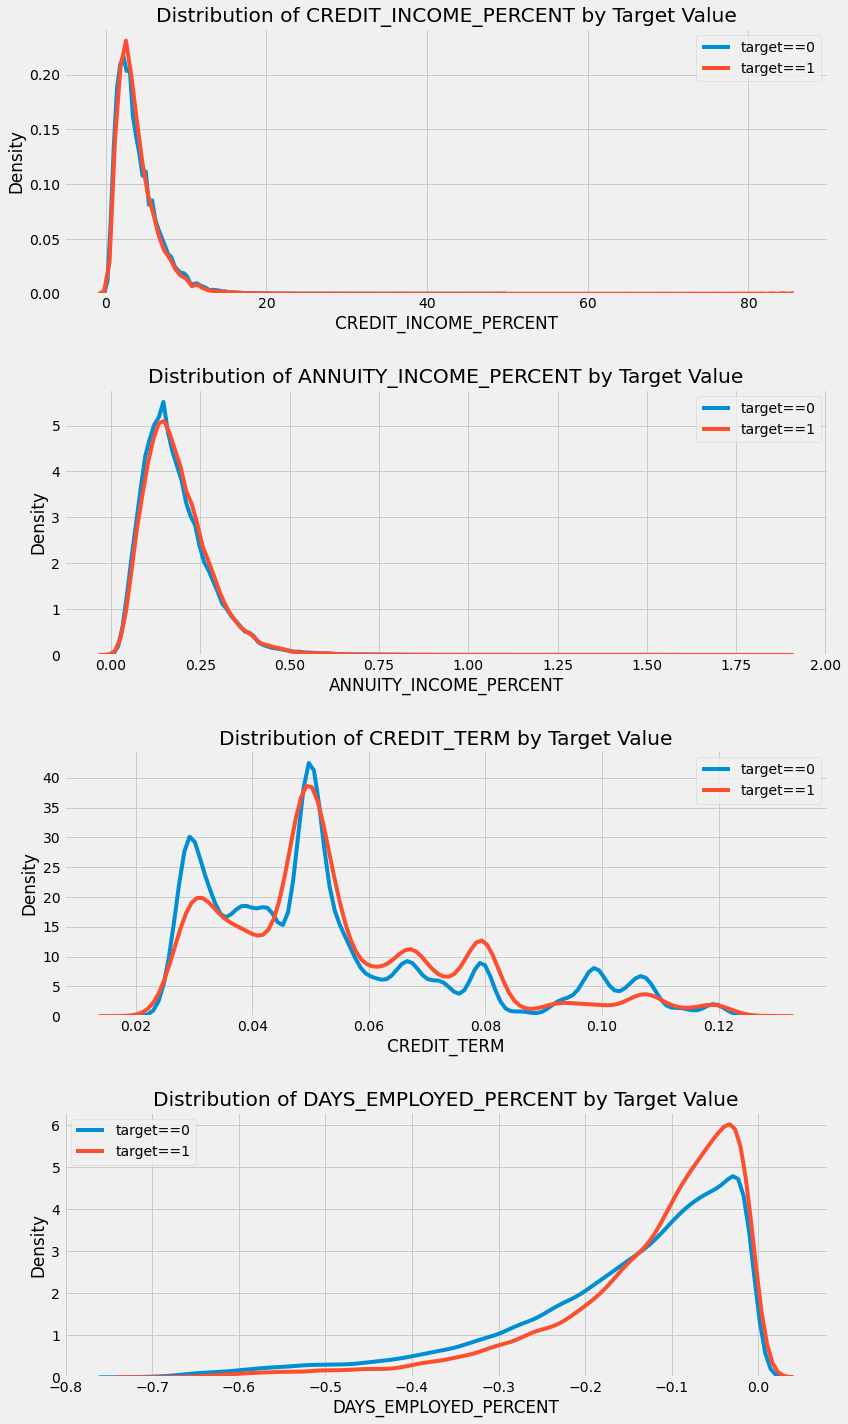

In [48]:
plt.figure(figsize=(12,20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT','ANNUITY_INCOME_PERCENT','CREDIT_TERM','DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4,1,i+1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET']==0,feature],label='target==0')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET']==1,feature],label='target==1')
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature);
    plt.ylabel('Density');
    
plt.tight_layout(h_pad=2.5)

* Target=0일때와 1일때 각 변수의 분포가 별 차이가없어서 이 feature가 유의미할지 테스트해보자

### Baseline
- 우리는 대출을 갚지 못할 확률을 예측하고자 한다. 그래서 만약 아예 모르겠다고하면 test set의 모든 관측치에 0.5라고 예측할수도있다. 이렇게하면 AUC ROC값이 0.5로 나올것이다.

## 8) Logistic Regression Implementation
- 모든 categorical 변수를 encoding한 것을 사용할것이다. 그리고 결측치를 imputation으로 채울것이고, 변수를 normalizing할것이다. 

In [49]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# training 데이터에서 TARGET 변수 drop -> TARGET변수는 결측치처리 및 Scaling대상아니기때문에
if 'TARGET' in app_train:
    train=app_train.drop(columns=['TARGET'])
else:
    train=app_train.copy()

# 변수이름
features=list(train.columns)

# testing 데이터 복사
test=app_test.copy()

# 결측치를 median값으로 처리
imputer = SimpleImputer(strategy='median')

'''
각 Feature의 값을 일정한 범위 또는 규칙에 따르게 하기 위해서 스케일링을 사용
'''
# 각각의 변수를 0~1 사이의 값으로 만들어주는 MinMaxScaler 사용
## MinMaxScaler 클래스의 인스턴스를 만들어준다
scaler=MinMaxScaler(feature_range=(0,1))

# training 데이터에 fit
imputer.fit(train)

# training데이터와 testing데이터에 둘다 transform
## imputer 처리 하고나면 DataFrame에서 array형태로 바뀜
train=imputer.transform(train)
test=imputer.transform(test)

# Scaling
scaler.fit(train)
train=scaler.transform(train)
test=scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


- 이제 LogisticRegression을 사용해볼것인데, 오버피팅을 조절해주는 regularization 파라미터 C 를 낮춰서 세팅을 해볼것이다. 
- 우선 log_reg라는 이름으로 model을 만들어주고, .fit()을 사용해서 모델을 훈련시키고, .predict_proba()를 사용해서 testing data에 대한 값을 예측할것이다.

In [50]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg=LogisticRegression(C=0.0001)

# Train on the training data
log_reg.fit(train,train_labels)

LogisticRegression(C=0.0001)

- 예측한 결과값은 mx2 배열로 나오는데(m은 관측치 개수),첫번째 컬럼은 target이 0일 확률이고 두번째 컬럼은 target이 1일 확률이다.(따라서, 두 컬럼의 합은 1이되어야함)
- 우리가 원하는 것은 대출을 갚지 못할 확률이므로, target=1일 확률인 두번째 컬럼을 선택해야한다.

In [51]:
# 두개의 컬럼이 나오는 것을 확인
log_reg.predict_proba(test)

array([[0.92148542, 0.07851458],
       [0.8620737 , 0.1379263 ],
       [0.91780633, 0.08219367],
       ...,
       [0.92277534, 0.07722466],
       [0.91761109, 0.08238891],
       [0.89786466, 0.10213534]])

In [52]:
# Make predictions
# 두번째 컬럼 선택
log_reg_pred=log_reg.predict_proba(test)[:,1]

In [53]:
# submission파일의 형식과 동일하게 SK_ID_CURR 와 TARGET이 들어가게 만들어준다
submit=app_test[['SK_ID_CURR']]
submit['TARGET']=log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.078515
1,100005,0.137926
2,100013,0.082194
3,100028,0.080921
4,100038,0.132618


In [54]:
# submission 데이터를 csv file로 저장
submit.to_csv('log_reg_baseline.csv',index=False)

* LogisticRegression Score : 0.67887

## 9) Improved Model: Random Forest
* 결정트리의 단점을 보완하고 장점은 그대로 가지고 있는 모델. 대표적인 '배깅' 모델이다.(배깅(Bagging)은 bootstrap aggregating의 줄임말)
* 훈련 과정에서 구성한 다수의 결정 트리들을 랜덤하게 학습시켜 분류 또는 회귀의 결과도출에 사용함.
* 기본 결정트리는 해당 데이터에 대해 맞춰서 분류를 진행한 것이기 때문에 과적합 현상이 자주 나타나는 단점이 있는데, 랜덤포레스트는 각각의 트리가 독립적으로 학습해서 이런 단점을 개선함.


### 하이퍼파라미터 튜닝
> **n_estimators**
    * 결정트리의 갯수를 지정 (Default=10)
    * 무작정 트리 갯수를 늘린다고해서 성능 좋아지는 것 아님.시간이 걸릴 수 있음
> **random_state**
    * 랜덤하게 만들어지기 때문에 random_state를 고정해야 같은 결과를 볼 수 있음
> **verbose**
    * 실행 과정 출력 여부
> **n_jobs**
    * 적합성과 예측성을 위해 병렬로 실행할 작업 수
    * n_jobs=-1로 지정하면 컴퓨터의 모든 코어를 사용함

In [55]:
from sklearn.ensemble import RandomForestClassifier

random_forest=RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)


In [56]:
# training data에 훈련
random_forest.fit(train, train_labels)

# feature importances 추출
feature_importance_values=random_forest.feature_importances_
feature_importances=pd.DataFrame({'feature':features, 'importance':feature_importance_values})

# test 데이터에 대해 예측
predictions=random_forest.predict_proba(test)[:,1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished


In [57]:
# 제출용 dataframe만들기
submit=app_test[['SK_ID_CURR']]
submit['TARGET']=predictions

# csv 파일 저장
submit.to_csv('random_forest_baseline.csv',index=False)

* RandomForest Score :

### 9-1) Feature engineering한 데이터로 예측해보자
* (참고) 기존 train 변수에 다항변수 추가한 app_train_poly데이터가 아니라, 다항변수만 있는 poly_features로 예측한값

In [58]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = SimpleImputer(strategy = 'median')

# poly_features는 다항변수만 있는 데이터
# app_train_poly는 기존 train 데이터에 다항변수 추가한 데이터
poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [59]:
# training data에 훈련시키기
random_forest_poly.fit(poly_features, train_labels)

# test데이터로 예측
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


In [60]:
submit=app_test[['SK_ID_CURR']]
submit['TARGET']=predictions

submit.to_csv('random_forest_baseline_engineered.csv',index=False)

* Random Forest engineered Score :0.60467

### 9-2) Domain기반으로 만든 feature로 예측해보자

In [61]:
app_train_domain.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,1,0,1,0,1,False,2.007889,0.121978,0.060749,-0.067329
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,1,0,0,False,4.790750,0.132217,0.027598,-0.070862
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,False,2.000000,0.100000,0.050000,-0.011814
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,False,2.316167,0.219900,0.094941,-0.159905
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,False,4.222222,0.179963,0.042623,-0.152418


In [62]:
# TARGET변수제거
app_train_domain=app_train_domain.drop(columns='TARGET')
# 도메인기반으로 만든 데이터의 변수명 추출
domain_features_names=list(app_train_domain.columns)

# 결측치 처리
imputer=SimpleImputer(strategy='median')
# imputer처리 해주고나면 DataFrame 형태에서 array형태로 바뀜
domain_features=imputer.fit_transform(app_train_domain)
domain_features_test=imputer.transform(app_test_domain)

# 랜덤포레스트 모델 만들기
random_forest_domain=RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

# 훈련시키기
random_forest_domain.fit(domain_features,train_labels)

# 변수 중요도 추출
feature_importance_values_domain=random_forest_domain.feature_importances_
feature_importances_domain=pd.DataFrame({'feature':domain_features_names,
                                        'importance':feature_importance_values_domain})

# test데이터 넣어서 예측하면 TARGET=0일 확률을 예측한 컬럼 한개와 TARGET=1일 확률을 예측한 컬럼 한개가 있는데
## 여기서 우리가 원하는것은 TARGET=1일때의 확률이므로 두번째 컬럼 선택해서 저장
predictions=random_forest_domain.predict_proba(domain_features_test)[:,1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


In [63]:
submit=app_test[['SK_ID_CURR']]
submit['TARGET']=predictions

submit.to_csv('random_forest_baseline_domain.csv',index=False)

* Random Forest domain features :0.68354

## 10) Model Interpretation: Feature Importances

* 어떤 변수가 가장 관련이 있는지를 알기위한 가장 간단한 방법은 랜덤포레스트의 feature importances를 확인하는 것이다. EDA과정에서 변수간 상관관계분석을 통해 EXT_SOURCE 변수와 DAYS_BIRTH 변수가 중요한 변수라고 생각해볼수있다.
* 나중에는 이 feature importances를 사용해서 차원을 줄여볼것이다.

In [64]:
def plot_feature_importances(df):
    # 중요도 높은 순으로 나열
    df=df.sort_values('importance',ascending=False).reset_index()
    
    # 중요도 전체합 대비 해당 변수의 중요도 비중변수 추가
    df['importance_normalized']=df['importance']/df['importance'].sum()
    
    # 시각화
    plt.figure(figsize=(10,6))
    ax=plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:15]))), df['importance_normalized'].head(15), align='center',edgecolor='k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [65]:
feature_importances

,feature,importance
0,SK_ID_CURR,0.030372
1,NAME_CONTRACT_TYPE,0.001824
2,FLAG_OWN_CAR,0.004197
3,FLAG_OWN_REALTY,0.005131
4,CNT_CHILDREN,0.007169
...,...,...
235,"WALLSMATERIAL_MODE_Stone, brick",0.001562
236,WALLSMATERIAL_MODE_Wooden,0.000456
237,EMERGENCYSTATE_MODE_No,0.001694
238,EMERGENCYSTATE_MODE_Yes,0.000396


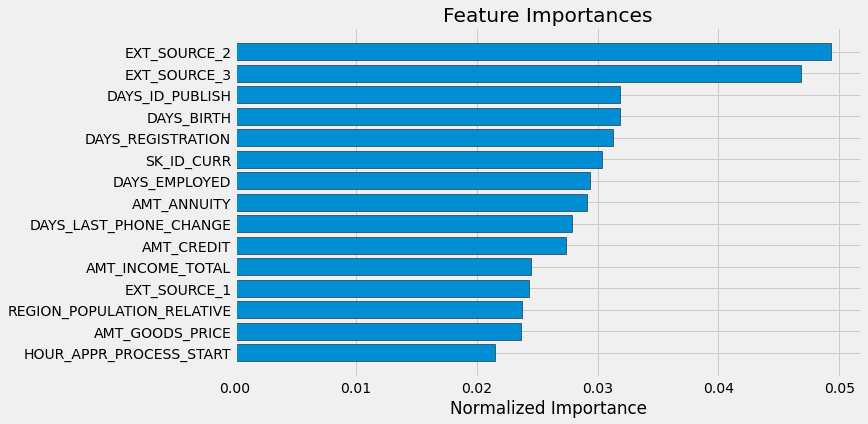

In [66]:
# feature engineering안한 기본 변수들로 변수 중요도 추출
feature_importances_sorted=plot_feature_importances(feature_importances)

* 예상했던것 처럼 EXT_SOURCE 변수와 DAYS_BIRTH 변수가 중요변수로 나온것을 확인.
* feature importances가 모델을 해석하고 차원을 줄이는데 가장 좋은 방법이라고 할 수는 없지만, 예측을 할때 모델이 어떤 요인을 고려하는지를 이해하는데 도움이 된다.

In [67]:
feature_importances

,feature,importance
0,SK_ID_CURR,0.030372
1,NAME_CONTRACT_TYPE,0.001824
2,FLAG_OWN_CAR,0.004197
3,FLAG_OWN_REALTY,0.005131
4,CNT_CHILDREN,0.007169
...,...,...
235,"WALLSMATERIAL_MODE_Stone, brick",0.001562
236,WALLSMATERIAL_MODE_Wooden,0.000456
237,EMERGENCYSTATE_MODE_No,0.001694
238,EMERGENCYSTATE_MODE_Yes,0.000396


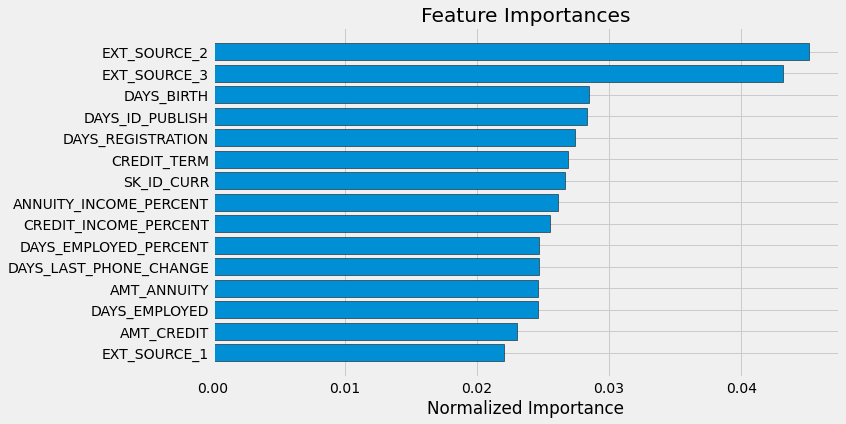

In [68]:
# domain기반으로 만든 변수 대상으로 변수 중요도 도출
feature_importances_domain_sorted=plot_feature_importances(feature_importances_domain)

* 도메인 기반으로 만든 4개의 변수가 변수 중요도 top15에 포함되어있는 것을 볼 수 있다. 
> 결론적으로, 도메인기반으로 만든 변수를 모델에 포함했을때가 score가 가장 좋았음.